In [2]:
# ! pip install sentencepiece
# ! pip install torchtext torch transformers


In [24]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

from collections import Counter



In [2]:
import os
import sys

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)
    
from utils.path_config import get_data_path
from utils.text_cleaning import clean_review_df
from utils.data_saving import save_with_rolling_backup
from utils.intent_mapping import apply_intent_mapping, inspect_potential_fp
import notebook_setup

Project root set to: D:\0) Abhay\04) SRH University Study Docs\Advance Programming\Python Files\Case Study Files
sys.path updated, project-level imports ready.


In [3]:
import os
import sys

models_path = os.path.abspath("../models")
if models_path not in sys.path:
    sys.path.append(models_path)

from shared import load_and_prepare_data, split_data, get_label_names


In [4]:
gold_df, _ = load_and_prepare_data()

In [5]:
gold_df

,overall,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,category,reviewText_imputed,intent_label,confidence_tag,merged_text,intent_label_clean,intent_label_encoded
20,5.0,True,"05 23, 2017",A4FJT3F0WNAK6,1620213982,My boyfriend loves this stand. It's very cute ...,I'm very happy with this purchase,1495497600,Beauty,False,PRODUCT_SEARCH,tier1_both,My boyfriend loves this stand. It's very cute ...,PRODUCT_SEARCH,4
58,5.0,True,"12 5, 2016",A2V15K9YDG3KMK,1620213982,Has a nice decently weighted base that allows ...,Has a nice decently weighted base that allows ...,1480896000,Beauty,False,VIEW_PRODUCT_DETAILS,tier1_both,Has a nice decently weighted base that allows ...,VIEW_PRODUCT_DETAILS,8
65,5.0,True,"11 5, 2016",A31QWNCUKJZ0L9,1620213982,Great product,Love it,1478304000,Beauty,False,SENTIMENT_PRAISE,tier1_both,Great product. Love it,SENTIMENT_PRAISE,7
68,5.0,True,"10 20, 2016",A1WN0CQFTTCF5W,1620213982,My husband loves it. Would recommend it to an...,Would recommend it to any one,1476921600,Beauty,False,VIEW_RECOMMENDATIONS,tier1_both,My husband loves it. Would recommend it to an...,VIEW_RECOMMENDATIONS,9
96,5.0,True,"06 20, 2016",A1J1TJMZYU9LJS,1620213982,"Nicely weighted and has a very classy look, mu...",Nicely weighted and has a very classy look,1466380800,Beauty,False,VIEW_PRODUCT_DETAILS,tier1_both,"Nicely weighted and has a very classy look, mu...",VIEW_PRODUCT_DETAILS,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74891,3.0,True,"10 27, 2017",A3T69E50FR3ZWC,B01F74A9RC,Received product July 12th and already not wor...,Received product July 12th and already not wor...,1509062400,Electronics,False,SENTIMENT_COMPLAINT,tier1_both,Received product July 12th and already not wor...,SENTIMENT_COMPLAINT,6
74901,3.0,True,"08 12, 2016",AKP5VKPUQ68V1,B01FHHORVI,An average rating mainly because of durability...,The actual performance and testing features ar...,1470960000,Electronics,False,VIEW_PRODUCT_DETAILS,tier1_both,An average rating mainly because of durability...,VIEW_PRODUCT_DETAILS,8
74906,4.0,True,"05 21, 2017",A1760TS5NZCWCS,B01FJXTYXQ,"Ok, its a plain antenna. people think this is ...",Just like every other antenna you find on Amaz...,1495324800,Electronics,False,PRODUCT_SEARCH,tier1_both,"Ok, its a plain antenna. people think this is ...",PRODUCT_SEARCH,4
74949,5.0,True,"09 28, 2018",A1GBDN694PFBHI,B01GE1ZOPY,My experience with any Audiotechnica product h...,Excellent Product,1538092800,Electronics,False,SENTIMENT_PRAISE,tier1_both,My experience with any Audiotechnica product h...,SENTIMENT_PRAISE,7


In [6]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# 1. Simple tokenizer
def simple_tokenizer(text):
    return text.lower().split()

# 2. Build vocabulary
all_tokens = [token for text in gold_df['merged_text'] for token in simple_tokenizer(text)]
token_freqs = Counter(all_tokens)

# 3. Reserve special tokens
vocab = {token: idx + 2 for idx, (token, _) in enumerate(token_freqs.items())}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

# 4. Convert texts to sequences
def text_to_sequence(text, vocab):
    return [vocab.get(token, vocab["<UNK>"]) for token in simple_tokenizer(text)]

gold_df["token_ids"] = gold_df["merged_text"].apply(lambda x: text_to_sequence(x, vocab))

# 5. Encode labels
label_encoder = LabelEncoder()
gold_df["label_encoded"] = label_encoder.fit_transform(gold_df["intent_label_clean"])


In [9]:
import numpy as np

# Path to GloVe file (downloaded separately; you can change this path)
glove_path = "glove.6B.100d.txt"

# Load embeddings into a dictionary
glove_embeddings = {}
with open(glove_path, "r", encoding="utf8") as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vec = np.array(parts[1:], dtype=np.float32)
        glove_embeddings[word] = vec

# Initialize embedding matrix
embedding_dim = 100
embedding_matrix = np.random.normal(0, 1, (len(vocab), embedding_dim)).astype(np.float32)
embedding_matrix[vocab["<PAD>"]] = np.zeros(embedding_dim)

# Replace entries with GloVe vectors if available
for token, idx in vocab.items():
    if token in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[token]


In [10]:
import numpy as np
import torch

# Create the embedding matrix
embedding_dim = 100  # since we're using glove.6B.100d
vocab_size = len(vocab)
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in vocab.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = glove_embeddings[word]
    else:
        embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


In [15]:
import torch.nn.functional as F
import torch.nn as nn

class BiLSTMWithAttention(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, dropout=0.3, num_layers=2):
        super(BiLSTMWithAttention, self).__init__()
        vocab_size, embed_dim = embedding_matrix.shape

        # Embedding layer using pretrained GloVe
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=False, padding_idx=vocab["<PAD>"])

        # Stacked BiLSTM
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True, dropout=dropout)

        # Attention
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Classification
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)                           # (batch_size, seq_len, embed_dim)
        lstm_out, _ = self.lstm(embedded)                      # (batch_size, seq_len, hidden_dim*2)

        # Attention weights
        attn_weights = F.softmax(self.attention(lstm_out), dim=1)  # (batch_size, seq_len, 1)
        context = torch.sum(attn_weights * lstm_out, dim=1)        # (batch_size, hidden_dim*2)

        out = self.dropout(context)
        return self.fc(out)


In [17]:
# Define device (CUDA if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model hyperparameters
HIDDEN_DIM = 128
OUTPUT_DIM = len(label_encoder.classes_)
DROPOUT = 0.3
NUM_LAYERS = 2

# Instantiate upgraded BiLSTM with Attention model
model = BiLSTMWithAttention(
    embedding_matrix=embedding_matrix,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    dropout=DROPOUT,
    num_layers=NUM_LAYERS
).to(device)


In [19]:
import torch.optim as optim

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer (AdamW for better regularization)
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Optional: Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)



In [20]:
def train_phd_rnn_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler=None, num_epochs=10, device="cuda"):
    best_val_loss = float('inf')
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            total_correct += (outputs.argmax(1) == labels).sum().item()

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = total_correct / len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f}")

        # Scheduler step and manual LR logging
        if scheduler:
            old_lr = optimizer.param_groups[0]['lr']
            scheduler.step(avg_val_loss)
            new_lr = optimizer.param_groups[0]['lr']
            if new_lr != old_lr:
                print(f"Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break


In [21]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Step 1: Extract data
sequences = gold_df["token_ids"].tolist()
labels = gold_df["label_encoded"].tolist()

# Step 2: Split
X_train, X_temp, y_train, y_temp = train_test_split(sequences, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Step 3: Custom Dataset Class
class RNNTextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.long)

# Step 4: Collate Function
def collate_fn(batch):
    sequences, labels = zip(*batch)
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=vocab["<PAD>"])
    return padded_sequences, torch.stack(labels)

# Step 5: DataLoaders
BATCH_SIZE = 32
train_loader = DataLoader(RNNTextDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(RNNTextDataset(X_val, y_val), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(RNNTextDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [22]:
train_phd_rnn_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    scheduler=scheduler,
    num_epochs=15,  # You can increase if needed
    device=device
)


Epoch 1/15 | Train Loss: 1.7707 | Train Acc: 0.3564 | Val Loss: 1.7461 | Val Acc: 0.4059
Epoch 2/15 | Train Loss: 1.6584 | Train Acc: 0.4119 | Val Loss: 1.6166 | Val Acc: 0.4645
Epoch 3/15 | Train Loss: 1.3533 | Train Acc: 0.5634 | Val Loss: 1.1837 | Val Acc: 0.6406
Epoch 4/15 | Train Loss: 0.9065 | Train Acc: 0.7301 | Val Loss: 1.0051 | Val Acc: 0.6968
Epoch 5/15 | Train Loss: 0.7127 | Train Acc: 0.7972 | Val Loss: 1.0418 | Val Acc: 0.7311
Epoch 6/15 | Train Loss: 0.5199 | Train Acc: 0.8512 | Val Loss: 0.7212 | Val Acc: 0.8020
Epoch 7/15 | Train Loss: 0.3714 | Train Acc: 0.8920 | Val Loss: 0.6960 | Val Acc: 0.8142
Epoch 8/15 | Train Loss: 0.2669 | Train Acc: 0.9219 | Val Loss: 0.7582 | Val Acc: 0.7897
Epoch 9/15 | Train Loss: 0.1984 | Train Acc: 0.9418 | Val Loss: 0.6058 | Val Acc: 0.8631
Epoch 10/15 | Train Loss: 0.1334 | Train Acc: 0.9659 | Val Loss: 0.6234 | Val Acc: 0.8680
Epoch 11/15 | Train Loss: 0.1050 | Train Acc: 0.9733 | Val Loss: 0.7600 | Val Acc: 0.8533
Epoch 12/15 | Train

In [26]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy and Report
    print("\nTest Accuracy:", round(accuracy_score(all_labels, all_preds), 4))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()



Test Accuracy: 0.8753

Classification Report:
                      precision    recall  f1-score   support

    CHECK_SALE_ITEMS       0.22      0.50      0.31         8
    CONNECT_TO_AGENT       0.43      0.50      0.46         6
             GOODBYE       0.50      0.80      0.62         5
               OTHER       0.00      0.00      0.00         1
      PRODUCT_SEARCH       0.97      0.94      0.96       114
         RETURN_ITEM       0.56      0.82      0.67        11
 SENTIMENT_COMPLAINT       0.85      0.82      0.84        28
    SENTIMENT_PRAISE       0.95      0.90      0.92       146
VIEW_PRODUCT_DETAILS       0.92      0.86      0.89        71
VIEW_RECOMMENDATIONS       0.89      0.84      0.86        19

            accuracy                           0.88       409
           macro avg       0.63      0.70      0.65       409
        weighted avg       0.90      0.88      0.89       409



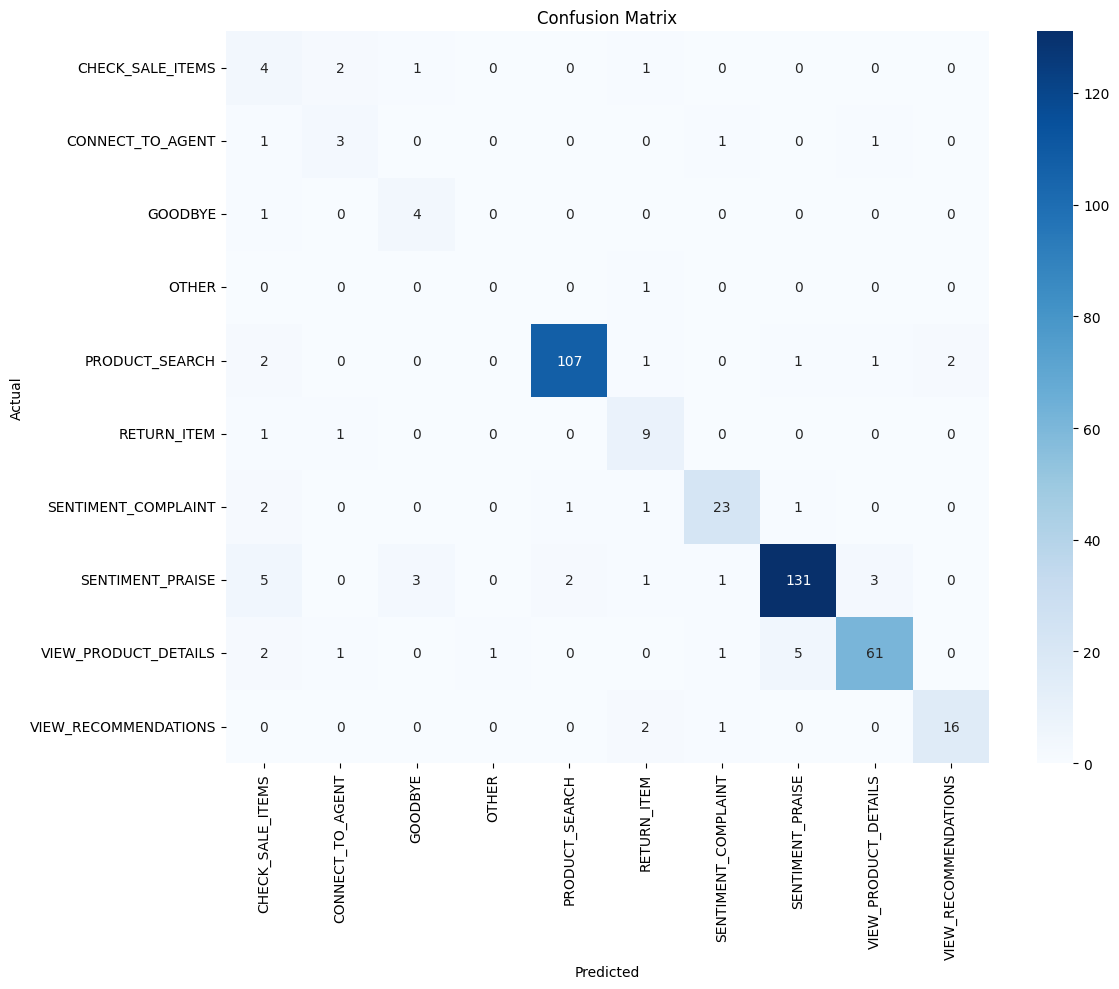

In [27]:
evaluate_model(model, test_loader, device)